# 09h: Fractal/Scaling Analysis

**Key Question:** Does the game tree have scale-invariant structure?

**Analyses:**
1. **Roughness Scaling**: How does V variance scale with window size?
2. **DFA (Hurst Exponent)**: Is there persistent memory (H > 0.5) or mean reversion (H < 0.5)?
3. **Branching Scaling**: How does tree size scale with depth?

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
from scipy import stats
import random
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files
val_files = loading.find_shard_files(DATA_DIR + "val/")
test_files = loading.find_shard_files(DATA_DIR + "test/")
train_files = loading.find_shard_files(DATA_DIR + "train/")

all_files = val_files + test_files
random.shuffle(all_files)
random.shuffle(train_files)
shard_files = all_files + train_files

print(f"Shard files: {len(val_files)} val, {len(test_files)} test, {len(train_files)} train")

N_SHARDS = 25
MAX_ROWS = 15_000_000
N_PATHS_TARGET = 150
print(f"Using up to {N_SHARDS} shards, target {N_PATHS_TARGET} paths")

Shard files: 95 val, 95 test, 1124 train
Using up to 25 shards, target 150 paths


## Data Collection: V-Trajectories

In [3]:
def trace_v_trajectory(start_state, seed, decl_id, state_to_idx, V, Q):
    """Trace V values along principal variation from start_state."""
    pv = navigation.trace_principal_variation(start_state, seed, decl_id, state_to_idx, V, Q)
    if len(pv) < 8:  # Need reasonable length for DFA
        return None
    
    v_values = np.array([v for _, v, _ in pv])
    return v_values


# Collect V-trajectories
all_V_trajectories = []
skipped = 0
processed = 0

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Collecting trajectories"):
    if len(all_V_trajectories) >= N_PATHS_TARGET:
        break
    
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        skipped += 1
        del df
        gc.collect()
        continue
    
    processed += 1
    
    states = df['state'].values
    V = df['V'].values
    q_cols = [c for c in df.columns if c.startswith('q')]
    Q = df[q_cols].values
    state_to_idx = {s: i for i, s in enumerate(states)}
    
    depths = features.depth(states)
    start_mask = (depths >= 24) & (depths <= 27)
    start_idx = np.where(start_mask)[0]
    
    if len(start_idx) > 0:
        sample_idx = np.random.choice(start_idx, min(8, len(start_idx)), replace=False)
        for idx in sample_idx:
            traj = trace_v_trajectory(states[idx], seed, decl_id, state_to_idx, V, Q)
            if traj is not None:
                all_V_trajectories.append(traj)
    
    del df, states, V, Q, state_to_idx
    gc.collect()

print(f"\nProcessed {processed} shards, skipped {skipped}")
print(f"Collected {len(all_V_trajectories)} V-trajectories")


Processed 6 shards, skipped 19
Collected 48 V-trajectories


In [4]:
# Trajectory length distribution
lengths = [len(t) for t in all_V_trajectories]
print(f"Path lengths: mean={np.mean(lengths):.1f}, min={np.min(lengths)}, max={np.max(lengths)}")

Path lengths: mean=25.9, min=25, max=28


## Analysis 1: Roughness Scaling

In [5]:
def compute_roughness(V_trajectories, windows):
    """Compute variance of ΔV for different window sizes."""
    results = []
    
    for w in windows:
        variances = []
        for V in V_trajectories:
            if len(V) > w:
                dV = V[w:] - V[:-w]
                if len(dV) > 1:
                    variances.append(np.var(dV))
        
        if len(variances) > 0:
            results.append({
                'window': w,
                'mean_variance': np.mean(variances),
                'std_variance': np.std(variances),
                'n_samples': len(variances)
            })
    
    return pd.DataFrame(results)


windows = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14]
roughness_df = compute_roughness(all_V_trajectories, windows)
print(roughness_df)

    window  mean_variance  std_variance  n_samples
0        1      15.790413      3.815486         48
1        2      25.285006      7.135573         48
2        3      33.169124     11.258936         48
3        4      39.070116     15.815572         48
4        5      47.863711     21.680356         48
5        6      52.967029     26.269890         48
6        7      56.138734     31.874346         48
7        8      56.696414     38.254105         48
8       10      62.339232     43.731547         48
9       12      58.916363     50.339080         48
10      14      62.421428     47.183509         48


In [6]:
# Fit power law: variance ~ window^(2H)
# In log-log: log(var) = 2H * log(window) + const

log_w = np.log(roughness_df['window'].values)
log_var = np.log(roughness_df['mean_variance'].values)

# Linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(log_w, log_var)
H_roughness = slope / 2  # variance ~ w^(2H)

print(f"\nRoughness Scaling:")
print(f"  Slope (2H): {slope:.3f}")
print(f"  Hurst exponent (H): {H_roughness:.3f}")
print(f"  R²: {r_value**2:.3f}")


Roughness Scaling:
  Slope (2H): 0.535
  Hurst exponent (H): 0.267
  R²: 0.945


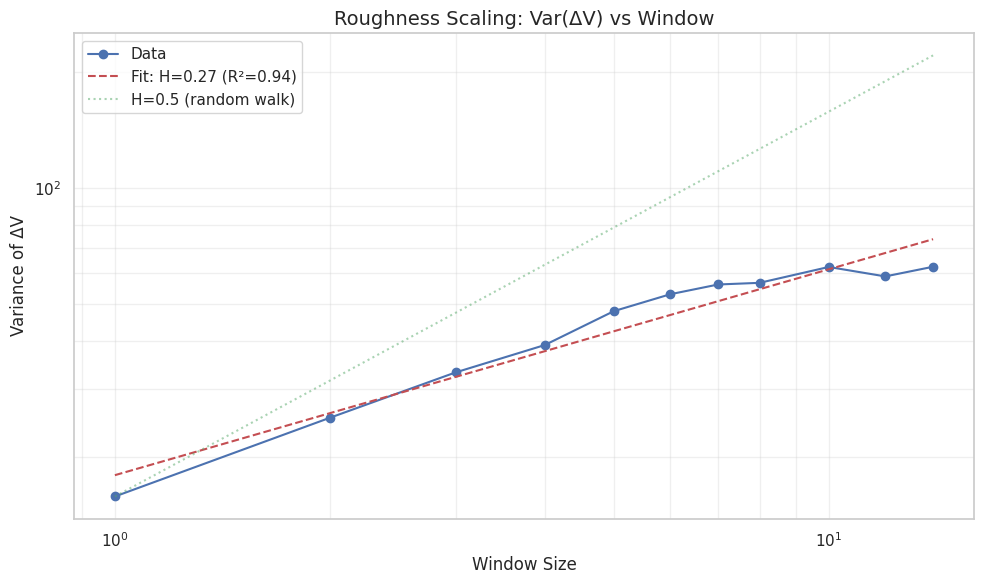

In [7]:
# Plot roughness scaling
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(roughness_df['window'], roughness_df['mean_variance'], 'b-o', label='Data')

# Fit line
fit_y = np.exp(intercept + slope * log_w)
ax.loglog(roughness_df['window'], fit_y, 'r--', 
          label=f'Fit: H={H_roughness:.2f} (R²={r_value**2:.2f})')

# Reference line for H=0.5 (random walk)
random_walk_y = roughness_df['mean_variance'].values[0] * (roughness_df['window'].values / roughness_df['window'].values[0])
ax.loglog(roughness_df['window'], random_walk_y, 'g:', alpha=0.5, label='H=0.5 (random walk)')

ax.set_xlabel('Window Size', fontsize=12)
ax.set_ylabel('Variance of ΔV', fontsize=12)
ax.set_title('Roughness Scaling: Var(ΔV) vs Window', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('../../results/figures/09h_roughness.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 2: Detrended Fluctuation Analysis (DFA)

In [8]:
def dfa(signal, scales):
    """Detrended Fluctuation Analysis for Hurst exponent."""
    n = len(signal)
    if n < 8:
        return None, None
    
    # Cumulative sum (integration)
    profile = np.cumsum(signal - np.mean(signal))
    
    fluctuations = []
    valid_scales = []
    
    for s in scales:
        if s > n // 2:
            continue
        
        # Number of segments
        n_segments = n // s
        if n_segments < 2:
            continue
        
        # Compute fluctuation for each segment
        segment_vars = []
        for i in range(n_segments):
            segment = profile[i*s:(i+1)*s]
            # Linear detrend
            x = np.arange(s)
            if len(segment) > 1:
                coef = np.polyfit(x, segment, 1)
                trend = np.polyval(coef, x)
                residual = segment - trend
                segment_vars.append(np.var(residual))
        
        if len(segment_vars) > 0:
            F_s = np.sqrt(np.mean(segment_vars))
            fluctuations.append(F_s)
            valid_scales.append(s)
    
    if len(valid_scales) < 2:
        return None, None
    
    return np.array(valid_scales), np.array(fluctuations)


# Compute DFA for all trajectories
scales = [3, 4, 5, 6, 7, 8, 10, 12]
all_hurst = []
all_dfa_results = []

for V in all_V_trajectories:
    s, F = dfa(V, scales)
    if s is not None and len(s) >= 3:
        # Fit power law: F ~ s^H
        log_s = np.log(s)
        log_F = np.log(F)
        slope, intercept, r, _, _ = stats.linregress(log_s, log_F)
        if r**2 > 0.7:  # Only use good fits
            all_hurst.append(slope)
            all_dfa_results.append({'scales': s, 'F': F, 'H': slope, 'R2': r**2})

print(f"Valid DFA fits: {len(all_hurst)} / {len(all_V_trajectories)}")
if len(all_hurst) > 0:
    mean_H = np.mean(all_hurst)
    std_H = np.std(all_hurst)
    print(f"\nHurst Exponent (DFA):")
    print(f"  Mean H: {mean_H:.3f} ± {std_H:.3f}")
    print(f"  Min H: {np.min(all_hurst):.3f}")
    print(f"  Max H: {np.max(all_hurst):.3f}")
else:
    mean_H = np.nan
    std_H = np.nan

Valid DFA fits: 7 / 48

Hurst Exponent (DFA):
  Mean H: 1.259 ± 0.397
  Min H: 0.787
  Max H: 1.976


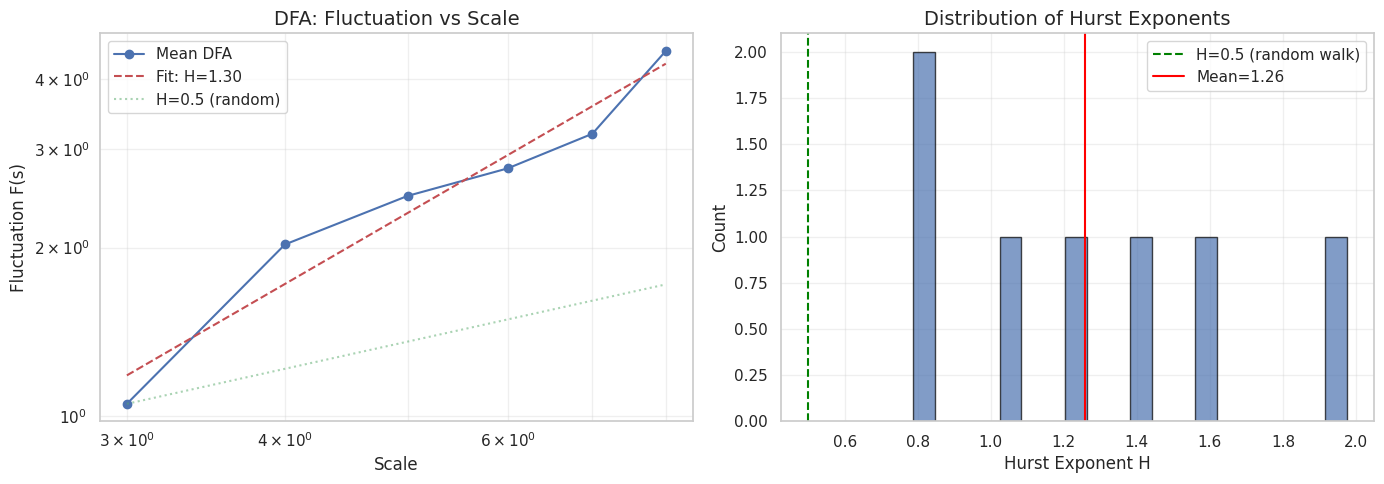

In [9]:
if len(all_dfa_results) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot average DFA curve
    # Aggregate scales and fluctuations
    common_scales = np.array([3, 4, 5, 6, 7, 8])
    F_by_scale = defaultdict(list)
    for res in all_dfa_results:
        for s, f in zip(res['scales'], res['F']):
            if s in common_scales:
                F_by_scale[s].append(f)
    
    mean_F = [np.mean(F_by_scale[s]) for s in common_scales if s in F_by_scale]
    valid_scales = [s for s in common_scales if s in F_by_scale]
    
    if len(valid_scales) > 2:
        ax1.loglog(valid_scales, mean_F, 'b-o', label='Mean DFA')
        
        # Fit line on mean
        log_s = np.log(valid_scales)
        log_F = np.log(mean_F)
        slope, intercept, _, _, _ = stats.linregress(log_s, log_F)
        fit_F = np.exp(intercept + slope * log_s)
        ax1.loglog(valid_scales, fit_F, 'r--', label=f'Fit: H={slope:.2f}')
        
        # Reference lines
        ref_05 = mean_F[0] * (np.array(valid_scales) / valid_scales[0]) ** 0.5
        ax1.loglog(valid_scales, ref_05, 'g:', alpha=0.5, label='H=0.5 (random)')
        
        ax1.set_xlabel('Scale', fontsize=12)
        ax1.set_ylabel('Fluctuation F(s)', fontsize=12)
        ax1.set_title('DFA: Fluctuation vs Scale', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3, which='both')
    
    # Histogram of Hurst exponents
    ax2.hist(all_hurst, bins=20, alpha=0.7, edgecolor='black')
    ax2.axvline(x=0.5, color='green', linestyle='--', label='H=0.5 (random walk)')
    ax2.axvline(x=mean_H, color='red', linestyle='-', label=f'Mean={mean_H:.2f}')
    ax2.set_xlabel('Hurst Exponent H', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Distribution of Hurst Exponents', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09h_dfa.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough valid DFA results to plot")

## Analysis 3: Tree Size Scaling

In [10]:
# Analyze how tree size scales with depth
# Count states at each depth across shards

depth_counts = defaultdict(list)

for shard_file in tqdm(shard_files[:15], desc="Counting by depth"):
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        del df
        gc.collect()
        continue
    
    depths = features.depth(df['state'].values)
    for d in range(1, 29):
        count = np.sum(depths == d)
        if count > 0:
            depth_counts[d].append(count)
    
    del df
    gc.collect()

# Compute mean counts by depth
scaling_data = []
for d in sorted(depth_counts.keys()):
    counts = depth_counts[d]
    scaling_data.append({
        'depth': d,
        'moves_from_start': 28 - d,  # 28 is root depth
        'mean_count': np.mean(counts),
        'std_count': np.std(counts),
        'n_shards': len(counts)
    })

scaling_df = pd.DataFrame(scaling_data)
print(scaling_df)

Counting by depth:   0%|          | 0/15 [00:00<?, ?it/s]

    depth  moves_from_start  mean_count     std_count  n_shards
0       1                27     8418.50  4.773094e+02         4
1       2                26     8418.50  4.773094e+02         4
2       3                25     8418.50  4.773094e+02         4
3       4                24     8418.50  4.773094e+02         4
4       5                23  1375006.25  2.296021e+05         4
5       6                22   812448.50  1.438869e+05         4
6       7                21   502009.50  9.176611e+04         4
7       8                20   251004.75  4.588305e+04         4
8       9                19  3973686.75  1.177008e+06         4
9      10                18  1839296.25  5.444932e+05         4
10     11                17   941880.75  2.783837e+05         4
11     12                16   313960.25  9.279456e+04         4
12     13                15   915913.50  3.301921e+05         4
13     14                14   381419.75  1.372793e+05         4
14     15                13   188252.00 


Exponential growth rate: 0.592 per move
Effective branching factor: 1.81


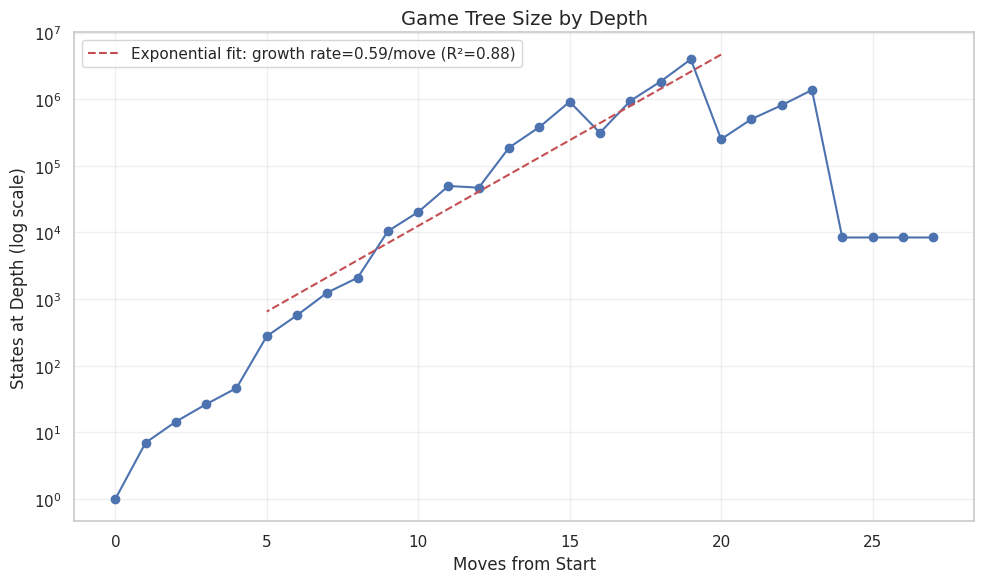

In [11]:
# Plot tree size scaling
fig, ax = plt.subplots(figsize=(10, 6))

# Use moves_from_start for x-axis (0 = root)
x = scaling_df['moves_from_start'].values
y = scaling_df['mean_count'].values

ax.semilogy(x, y, 'b-o')
ax.set_xlabel('Moves from Start', fontsize=12)
ax.set_ylabel('States at Depth (log scale)', fontsize=12)
ax.set_title('Game Tree Size by Depth', fontsize=14)
ax.grid(True, alpha=0.3)

# Fit exponential growth in middle region
mid_mask = (x >= 5) & (x <= 20)
if mid_mask.sum() >= 3:
    x_mid = x[mid_mask]
    log_y_mid = np.log(y[mid_mask])
    slope, intercept, r, _, _ = stats.linregress(x_mid, log_y_mid)
    
    fit_y = np.exp(intercept + slope * x_mid)
    ax.semilogy(x_mid, fit_y, 'r--', 
                label=f'Exponential fit: growth rate={slope:.2f}/move (R²={r**2:.2f})')
    ax.legend()
    
    growth_rate = slope
    print(f"\nExponential growth rate: {growth_rate:.3f} per move")
    print(f"Effective branching factor: {np.exp(growth_rate):.2f}")
else:
    growth_rate = np.nan

plt.tight_layout()
plt.savefig('../../results/figures/09h_tree_scaling.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary Statistics

In [12]:
summary_data = {
    'metric': [
        'Total V-trajectories',
        'Mean trajectory length',
        'Hurst (roughness scaling)',
        'Hurst (DFA mean)',
        'Hurst (DFA std)',
        'Exponential growth rate',
        'Effective branching factor',
    ],
    'value': [
        len(all_V_trajectories),
        f"{np.mean(lengths):.1f}",
        f"{H_roughness:.3f}" if not np.isnan(H_roughness) else "N/A",
        f"{mean_H:.3f}" if not np.isnan(mean_H) else "N/A",
        f"{std_H:.3f}" if not np.isnan(std_H) else "N/A",
        f"{growth_rate:.3f}" if 'growth_rate' in dir() and not np.isnan(growth_rate) else "N/A",
        f"{np.exp(growth_rate):.2f}" if 'growth_rate' in dir() and not np.isnan(growth_rate) else "N/A",
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/tables/09h_fractal.csv', index=False)
print("\nSaved to results/tables/09h_fractal.csv")

                    metric value
      Total V-trajectories    48
    Mean trajectory length  25.9
 Hurst (roughness scaling) 0.267
          Hurst (DFA mean) 1.259
           Hurst (DFA std) 0.397
   Exponential growth rate 0.592
Effective branching factor  1.81

Saved to results/tables/09h_fractal.csv


## Conclusion

In [13]:
print("=" * 60)
print("FRACTAL/SCALING ANALYSIS CONCLUSIONS")
print("=" * 60)

print(f"\n1. HURST EXPONENT")
if not np.isnan(H_roughness):
    print(f"   Roughness scaling H: {H_roughness:.3f}")
if not np.isnan(mean_H):
    print(f"   DFA mean H: {mean_H:.3f} ± {std_H:.3f}")
    
    if mean_H > 0.6:
        print(f"   PERSISTENT: Early advantages compound (H > 0.5)")
    elif mean_H < 0.4:
        print(f"   MEAN-REVERTING: Game corrects toward equilibrium (H < 0.5)")
    else:
        print(f"   NEAR RANDOM WALK: Limited long-range dependence (H ≈ 0.5)")

print(f"\n2. TREE SCALING")
if 'growth_rate' in dir() and not np.isnan(growth_rate):
    print(f"   Growth rate: {growth_rate:.3f} per move")
    print(f"   Effective branching: {np.exp(growth_rate):.2f}")
    if np.exp(growth_rate) > 1.5:
        print(f"   EXPONENTIAL GROWTH: Tree expands rapidly")
    else:
        print(f"   CONSTRAINED GROWTH: Limited branching")

print("\n" + "=" * 60)

FRACTAL/SCALING ANALYSIS CONCLUSIONS

1. HURST EXPONENT
   Roughness scaling H: 0.267
   DFA mean H: 1.259 ± 0.397
   PERSISTENT: Early advantages compound (H > 0.5)

2. TREE SCALING
   Growth rate: 0.592 per move
   Effective branching: 1.81
   EXPONENTIAL GROWTH: Tree expands rapidly

